In [ ]:
from plotting import plot_model_history

# Problem 2, Parts A-B: Boosted Decision Tree

In this Jupyter notebook, we will train a boosted decision tree on the MiniBooNE dataset.

Use this notebook to write your code for problem 1 parts A-B by filling in the sections marked `# TODO` and running all cells.

In [34]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

data = fetch_openml("miniboone", parser="auto", version=1)
X, y = data["data"].values, (data["target"].values == "True").astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# print dimensions of the datasets
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

# filter out rows containing the -999 sentinel in ANY feature
train_mask = (X_train != -999).all(axis=1)
test_mask = (X_test != -999).all(axis=1)

X_train_filtered = X_train[train_mask]
X_test_filtered = X_test[test_mask]
y_train_filtered = y_train[train_mask]
y_test_filtered = y_test[test_mask]

# print the new dimensions of the filtered datasets
print("X_train_filtered shape: ", X_train_filtered.shape)
print("y_train_filtered shape: ", y_train_filtered.shape)
print("X_test_filtered shape: ", X_test_filtered.shape)
print("y_test_filtered shape: ", y_test_filtered.shape)

X_train shape:  (104051, 50)
y_train shape:  (104051,)
X_test shape:  (26013, 50)
y_test shape:  (26013,)
X_train_filtered shape:  (103675, 50)
y_train_filtered shape:  (103675,)
X_test_filtered shape:  (25921, 50)
y_test_filtered shape:  (25921,)


In [35]:
# sanity checks after filtering
print("Number of -999 values in X_train_filtered:", np.sum(X_train_filtered == -999))
print("Number of -999 values in X_test_filtered:", np.sum(X_test_filtered == -999))
print("Number of nan values in X_train_filtered:", np.sum(np.isnan(X_train_filtered)))
print("Number of nan values in X_test_filtered:", np.sum(np.isnan(X_test_filtered)))
print("Number of inf values in X_train_filtered:", np.sum(np.isinf(X_train_filtered)))
print("Number of inf values in X_test_filtered:", np.sum(np.isinf(X_test_filtered)))
print("All train entries finite:", np.isfinite(X_train_filtered).all())
print("All test entries finite:", np.isfinite(X_test_filtered).all())

# print all min and max values for each feature of X
for feature_idx in range(X_train_filtered.shape[1]):
	train_min = np.min(X_train_filtered[:, feature_idx])
	train_max = np.max(X_train_filtered[:, feature_idx])
	test_min = np.min(X_test_filtered[:, feature_idx])
	test_max = np.max(X_test_filtered[:, feature_idx])
	print(
		f"Feature {feature_idx:2d} | "
		f"train[min,max]=({train_min:.6g}, {train_max:.6g}) | "
		f"test[min,max]=({test_min:.6g}, {test_max:.6g})"
    )

Number of -999 values in X_train_filtered: 0
Number of -999 values in X_test_filtered: 0
Number of nan values in X_train_filtered: 0
Number of nan values in X_test_filtered: 0
Number of inf values in X_train_filtered: 0
Number of inf values in X_test_filtered: 0
All train entries finite: True
All test entries finite: True
Feature  0 | train[min,max]=(0, 17.0573) | test[min,max]=(0, 16.0604)
Feature  1 | train[min,max]=(0.0707482, 8.80282) | test[min,max]=(0.0596913, 7.66563)
Feature  2 | train[min,max]=(0.0123806, 4747.67) | test[min,max]=(0.0392624, 4266.45)
Feature  3 | train[min,max]=(0.104697, 0.704169) | test[min,max]=(0.109527, 0.736804)
Feature  4 | train[min,max]=(-0.156118, 0.179012) | test[min,max]=(-0.136905, 0.174658)
Feature  5 | train[min,max]=(0, 0.703859) | test[min,max]=(0, 0.604472)
Feature  6 | train[min,max]=(0, 6.24108) | test[min,max]=(0, 4.60401)
Feature  7 | train[min,max]=(0.041932, 0.982981) | test[min,max]=(0.0335104, 0.989713)
Feature  8 | train[min,max]=(2.

In [36]:
# ! pip install xgboost

In [37]:
import xgboost as xgb
from xgboost import XGBClassifier
# help(XGBClassifier)

## Problem 1A

Using the MiniBooNE dataset and XGBoost, train a boosted decision tree on the
training dataet. Use the Scikit-learn API xgboost.XGBClassifier. For an initial choice of hyperparam-
eters use 100 trees (n_estimators), maximum tree depth (max_depth) of 10, learning rate (learning_-
rate) of 0.1, colsample_bytree of 0.8, and subsample of 0.8.

In [38]:
bdt = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, colsample_bytree=0.8, subsample=0.8)

bdt.fit(X_train_filtered, y_train_filtered)

# retrieve predictions and take index [:, 1] corresponding to signal
preds_bdt = bdt.predict_proba(X_test_filtered)[:, 1]

Plot the receiver operating characteristic (ROC) curve using the testing dataset. What area under the curve
(AUC) and accuracy do you achieve “out of the box”?

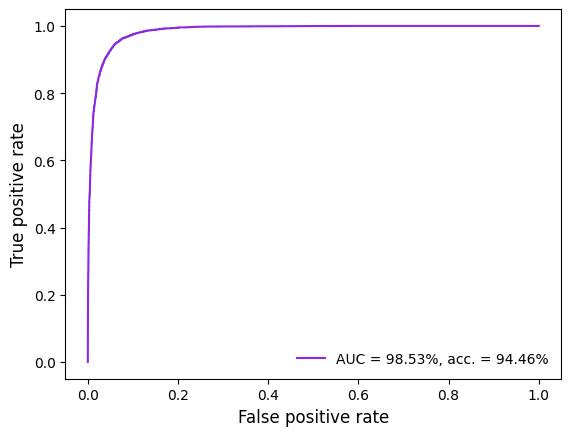

Out of the box AUC score:  0.9853333691641539


In [ ]:
from roc_helper import plot_roc
from sklearn.metrics import roc_auc_score

plot_roc(y_test_filtered, preds_bdt)

print("Out of the box AUC score: ", roc_auc_score(y_test_filtered, preds_bdt))

## Problem B

Plot the F -score for all the 10 “most important” features using xgboost.plot_-
importance. Which feature is the most important?

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

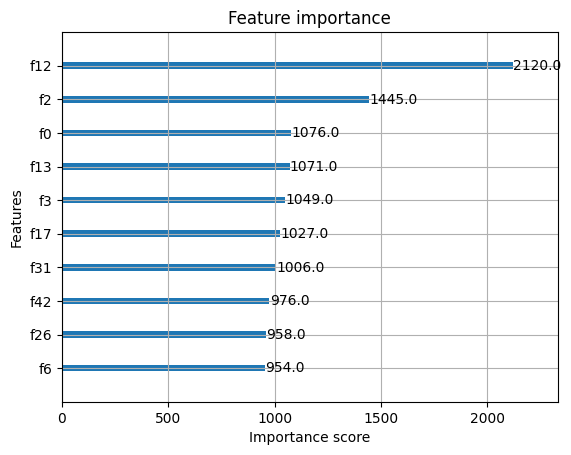

In [39]:
xgb.plot_importance(bdt, max_num_features=10)

Plot this feature using the testing dataset in a 1D histogram separately for signal and background. For the
histogram binning, use 100 bins from the minimum value of this feature to the maximum value of this
feature in the testing dataset. What do you notice about this feature?

In [40]:
print("feature importances:", bdt.feature_importances_)
mostImportantFeatureIndex = bdt.feature_importances_.argmax()
print("index of most important feature:", mostImportantFeatureIndex)

feature importances: [0.15744042 0.04005584 0.06105227 0.01814788 0.00976868 0.01615861
 0.01002657 0.00559988 0.01047468 0.01171287 0.00847025 0.01755949
 0.02532551 0.01314844 0.00589246 0.02176288 0.21118349 0.01247786
 0.00749157 0.00852642 0.01507393 0.00540459 0.01422502 0.01035366
 0.00716532 0.01012424 0.02838334 0.01274519 0.00867581 0.00912567
 0.00829527 0.05480712 0.00753342 0.00927151 0.00614356 0.00722038
 0.01005467 0.00703015 0.00856305 0.00719818 0.00736588 0.00731477
 0.00925392 0.00582307 0.01144512 0.0112385  0.00703905 0.00983341
 0.00538994 0.00562628]
index of most important feature: 16


feature min, max: 0.00378816 3.74218
unique values count: 25396


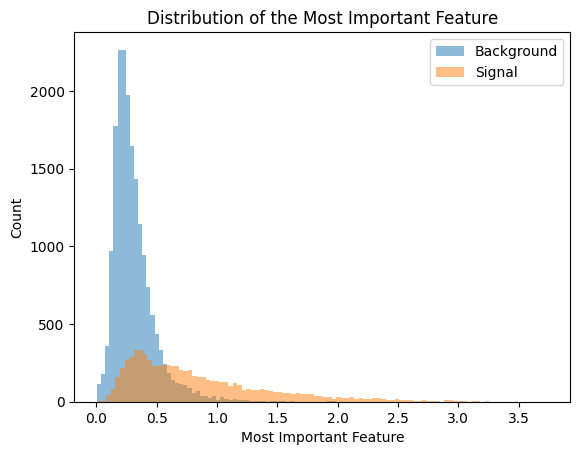

In [41]:
import numpy as np
import matplotlib.pyplot as plt

feat_vals = X_test_filtered[:, mostImportantFeatureIndex]

xmin = np.nanmin(feat_vals)
xmax = np.nanmax(feat_vals)

signal_vals = X_test_filtered[y_test_filtered == 1, mostImportantFeatureIndex]
background_values = X_test_filtered[y_test_filtered == 0, mostImportantFeatureIndex]

print("feature min, max:", xmin, xmax)
print("unique values count:", len(np.unique(feat_vals)))

# Create 100 bins between min and max (101 edges)
bins = 100

plt.hist(background_values, bins=bins, alpha=0.5, label="Background")
plt.hist(signal_vals, bins=bins, alpha=0.5, label="Signal")
plt.xlabel("Most Important Feature")
plt.ylabel("Count")
plt.title("Distribution of the Most Important Feature")
plt.legend()
plt.show()

The feature is a strong discriminator: the signal distribution is shifted to larger values than background and is much wider (longer tail).
There is still overlap around the central region (medians are separated but not disjoint), so it’s useful but not perfectly separable alone.
The signal’s heavy tail and positive skew suggest potential benefit from scaling or a transform (e.g. log or StandardScaler) before using in a neural net.

Lets see how well it performs with just this feature:

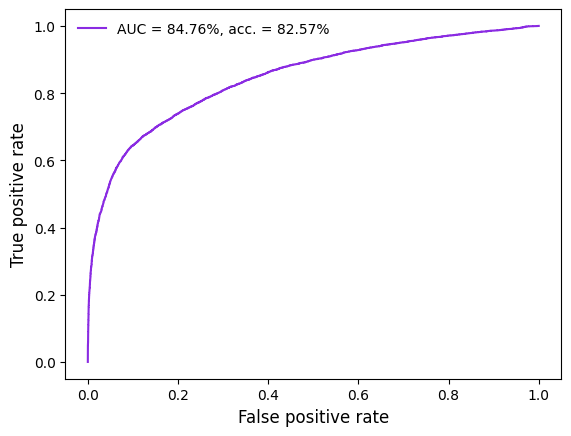

In [46]:
from roc_helper import plot_roc

feat = X_test_filtered[:, mostImportantFeatureIndex]
auc_score = roc_auc_score(y_test_filtered, feat)
plot_roc(y_test_filtered, feat)
plt.close()

Already very good!

# Problem 2, Parts C-E: Neural Network

In this Jupyter notebook, we will train a neural network on the MiniBooNE dataset.

Use this notebook to write your code for problem 1 parts C-E by filling in the sections marked `# TODO` and running all cells.

## Problem C
Using the MiniBooNE dataset and the Keras Model API, train a neural network
with 3 hidden layers each with 128 units and tanh activations. The final layer should have sigmoid activa-
tion. Use the binary crossentropy loss function, the SGD optimizer with a learning rate of 0.01 (which is the
default), and a batch size of 128. Train the model for 50 epochs.

In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

inputs = Input(shape=(X_train_filtered.shape[1],))
x = Dense(128, activation='tanh')(inputs)
x = Dense(128, activation='tanh')(x)
x = Dense(128, activation='tanh')(x)
outputs = Dense(1, activation='sigmoid')(x)
model_c = Model(inputs=inputs, outputs=outputs)

model_c.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history_c = model_c.fit(X_train_filtered, y_train_filtered, epochs=50, batch_size=128, validation_data=(X_test_filtered, y_test_filtered))

# retrieve predictions
preds_nn_c = model_c.predict(X_test_filtered)

Epoch 1/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8424 - loss: 0.3633 - val_accuracy: 0.8112 - val_loss: 0.3918
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8387 - loss: 0.3627 - val_accuracy: 0.8475 - val_loss: 0.3553
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8419 - loss: 0.3630 - val_accuracy: 0.8444 - val_loss: 0.3525
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8420 - loss: 0.3633 - val_accuracy: 0.8390 - val_loss: 0.3779
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8360 - loss: 0.3762 - val_accuracy: 0.7857 - val_loss: 0.4447
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8211 - loss: 0.4089 - val_accuracy: 0.8214 - val_loss: 0.4674
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8062 - loss: 0.4501 - val_accuracy: 0.8278 - val_loss: 0.3928
Epoch 8/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8112 - loss: 0.4191 - val_accuracy: 0.

Plot the receiver operating characteristic (ROC) curve using the testing dataset. What AUC and accuracy
do you achieve “out of the box”?

Out of the box AUC score:  0.9105179162013494


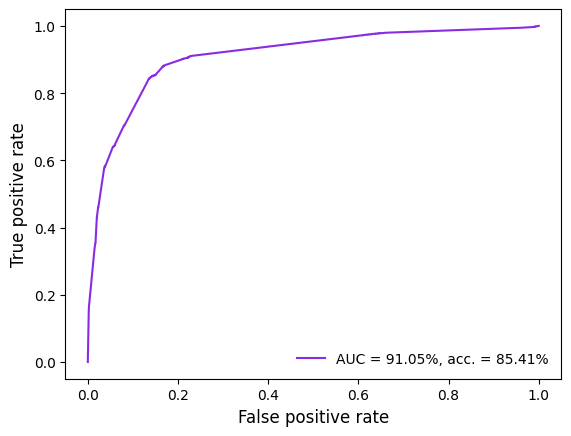

In [48]:
print("Out of the box AUC score: ", roc_auc_score(y_test_filtered, preds_nn_c))
roc_c = plot_roc(y_test_filtered, preds_nn_c)
plt.close()

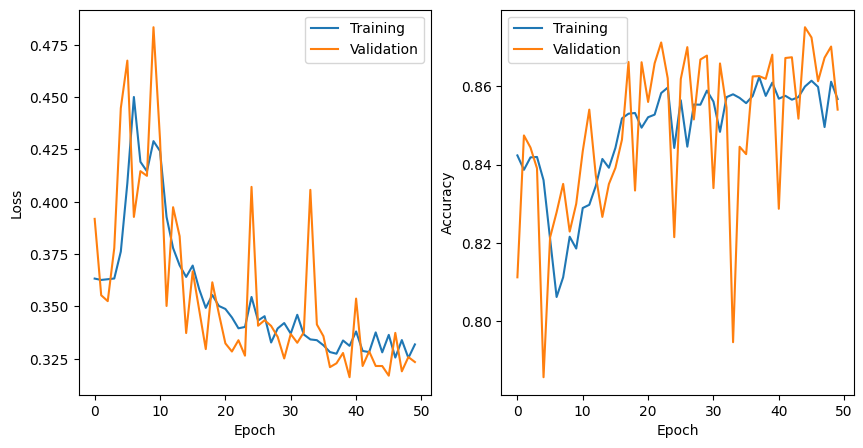

In [59]:
plot_model_history(history_c)

This is not too bad but not good either. This is because tanh works best when the values are around 0 with a standard deviation of 1. Higher values >> 1 or << 1 get mapped to ~1 so the activation cannot act on the values as well. This can be helped with scaling.

## Problem D
Swap out the tanh activations for ReLU activations, while keeping everything else
the same. Does the network train effectively? Why or why not?

In [56]:
inputs = Input(shape=(X_train_filtered.shape[1],))
x = Dense(128, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model_d = Model(inputs=inputs, outputs=outputs)

model_d.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history_d = model_d.fit(X_train_filtered, y_train_filtered, epochs=50, batch_size=128, validation_data=(X_test_filtered, y_test_filtered))

# retrieve predictions
preds_nn_d = model_d.predict(X_test_filtered)

Epoch 1/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7141 - loss: 7733393920.0000 - val_accuracy: 0.7163 - val_loss: 0.5988
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7190 - loss: 0.5947 - val_accuracy: 0.7163 - val_loss: 0.5964
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7190 - loss: 0.5939 - val_accuracy: 0.7163 - val_loss: 0.5964
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7190 - loss: 0.5939 - val_accuracy: 0.7163 - val_loss: 0.5964
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7190 - loss: 0.5939 - val_accuracy: 0.7163 - val_loss: 0.5964
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7190 - loss: 0.5939 - val_accuracy: 0.7163 - val_loss: 0.5964
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7190 - loss: 0.5939 - val_accuracy: 0.7163 - val_loss: 0.5964
Epoch 8/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7190 - loss: 0.5939 - val_acc

Numerical instability / overflow on the first weight update: unscaled large positive inputs + ReLU produce very large activations whihc gives huge gradients/weight updates -> Inf/NaN in logits or loss. Sometimes when running the cell above I get nan for loss and it breaks for this reason. 

ReLU without scaling score:  0.5


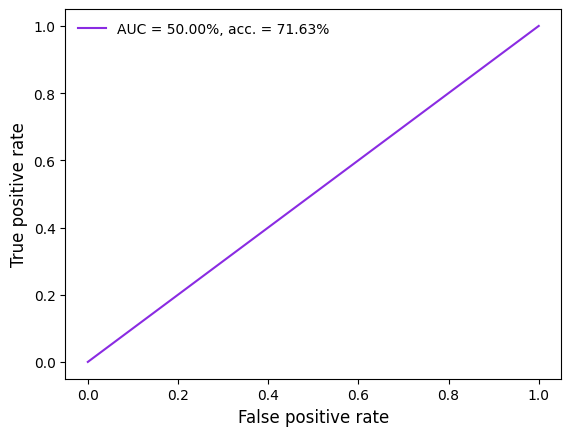

In [57]:
print("ReLU without scaling score: ", roc_auc_score(y_test_filtered, preds_nn_d))
roc_d = plot_roc(y_test_filtered, preds_nn_d)
plt.close()

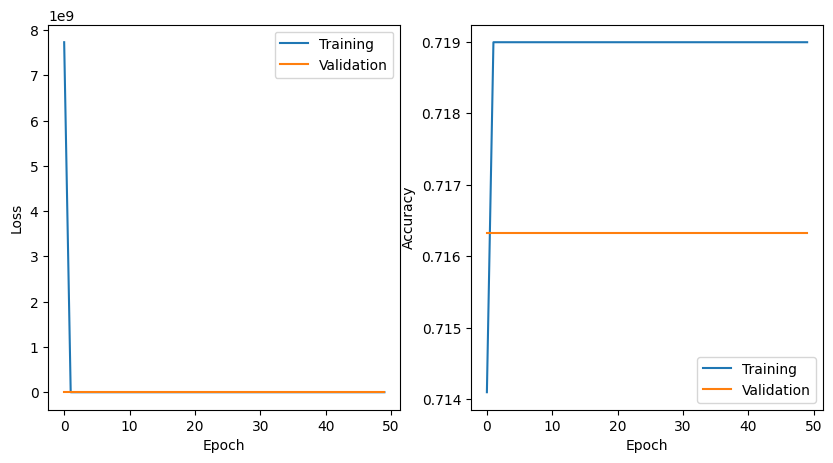

In [58]:
plot_model_history(history_d)

This is horrible, it's 50% - %50, so completely randomly guessing. For the features all values are already positive (x > 0) so ReLU (max(0, x)) acts like a linear model for most features. In problem E we will standardize the input features so it shouldnt be a problem anymore.

## Problem E
Now, we will make two minor changes to the network with ReLU activations:
preprocessing and the optimizer.
For the feature preprocessing use sklearn.preprocessing.StandardScaler to standardize the input
features. Note you should ﬁt the standard scaler to the training data only and apply it to both the training
and testing data. For the optimizer, use Adam with a learning rate of 0.001 (which is the default) instead of
SGD. Train the model for 50 epochs

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

In [61]:
# print all min and max values for each feature of X
for feature_idx in range(X_train_scaled.shape[1]):
	train_min = np.min(X_train_scaled[:, feature_idx])
	train_max = np.max(X_train_scaled[:, feature_idx])
	test_min = np.min(X_test_scaled[:, feature_idx])
	test_max = np.max(X_test_scaled[:, feature_idx])
	print(
		f"Feature {feature_idx:2d} | "
		f"train_scaled[min,max]=({train_min:.6g}, {train_max:.6g}) | "
		f"test_scaled[min,max]=({test_min:.6g}, {test_max:.6g})"
	)

Feature  0 | train_scaled[min,max]=(-4.18872, 10.4987) | test_scaled[min,max]=(-4.18872, 9.64031)
Feature  1 | train_scaled[min,max]=(-1.65225, 8.49562) | test_scaled[min,max]=(-1.6651, 7.17405)
Feature  2 | train_scaled[min,max]=(-0.687905, 24.7797) | test_scaled[min,max]=(-0.687761, 22.1983)
Feature  3 | train_scaled[min,max]=(-2.99522, 7.06401) | test_scaled[min,max]=(-2.91417, 7.61163)
Feature  4 | train_scaled[min,max]=(-13.2572, 13.6022) | test_scaled[min,max]=(-11.7174, 13.2533)
Feature  5 | train_scaled[min,max]=(-1.30515, 4.41768) | test_scaled[min,max]=(-1.30515, 3.6096)
Feature  6 | train_scaled[min,max]=(-2.82584, 15.3475) | test_scaled[min,max]=(-2.82584, 10.5805)
Feature  7 | train_scaled[min,max]=(-11.1038, 2.25953) | test_scaled[min,max]=(-11.2234, 2.35513)
Feature  8 | train_scaled[min,max]=(-4.07694, 13.6915) | test_scaled[min,max]=(-4.16267, 14.3793)
Feature  9 | train_scaled[min,max]=(-3.21021, 7.801) | test_scaled[min,max]=(-2.93826, 8.02441)
Feature 10 | train_sca

We see now the features have data points in the negative range as well, so ReLU can act better on it in a non-linear way.

In [62]:
inputs = Input(shape=X_train_scaled.shape[1:])
outputs = Dense(128, activation='relu')(inputs)
outputs = Dense(128, activation='relu')(outputs)
outputs = Dense(128, activation='relu')(outputs)
outputs = Dense(1, activation='sigmoid')(outputs)
model_e = Model(inputs=inputs, outputs=outputs)

model_e.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_e = model_e.fit(X_train_scaled, y_train_filtered, epochs=50, batch_size=128, validation_data=(X_test_scaled, y_test_filtered))

preds_nn_e = model_e.predict(X_test_scaled)

Epoch 1/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9296 - loss: 0.1777 - val_accuracy: 0.9394 - val_loss: 0.1530
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9431 - loss: 0.1440 - val_accuracy: 0.9446 - val_loss: 0.1392
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9463 - loss: 0.1360 - val_accuracy: 0.9462 - val_loss: 0.1373
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9494 - loss: 0.1294 - val_accuracy: 0.9465 - val_loss: 0.1363
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9510 - loss: 0.1255 - val_accuracy: 0.9472 - val_loss: 0.1348
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9520 - loss: 0.1217 - val_accuracy: 0.9470 - val_loss: 0.1365
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9536 - loss: 0.1173 - val_accuracy: 0.9465 - val_loss: 0.1374
Epoch 8/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9553 - loss: 0.1147 - val_accuracy: 0.

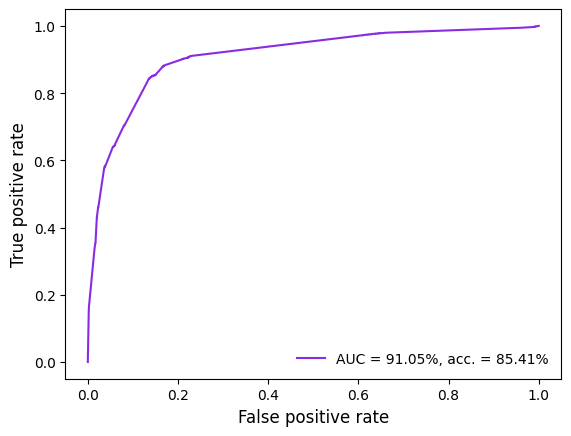

In [63]:
roc_c

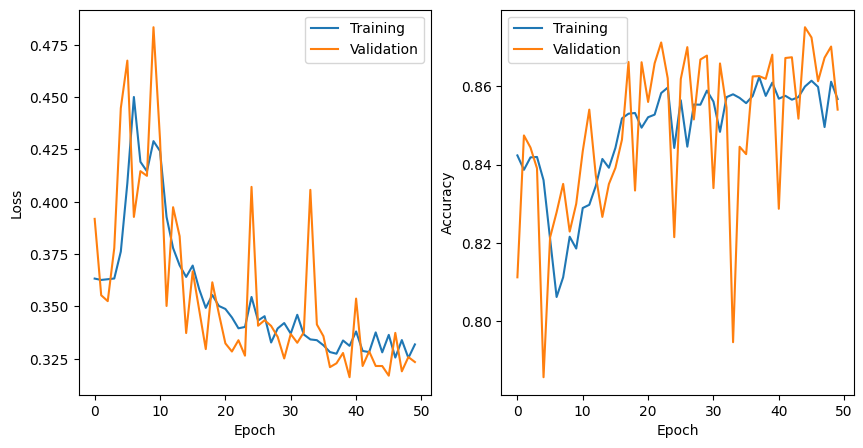

In [64]:
plot_model_history(history_c)

Scaled AUC score:  0.9802993512717129


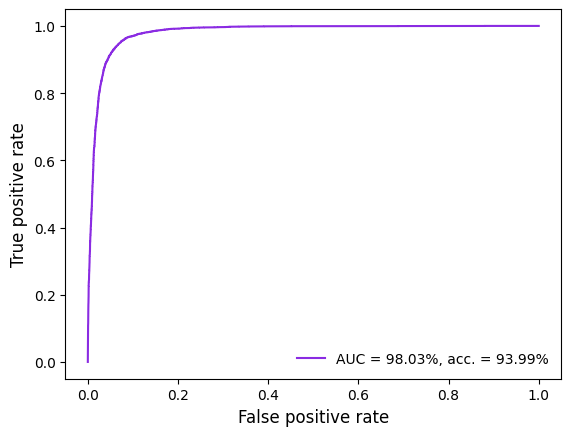

In [65]:
print("Scaled AUC score: ", roc_auc_score(y_test_filtered, preds_nn_e))
roc_e = plot_roc(y_test_filtered, preds_nn_e)
plt.close()

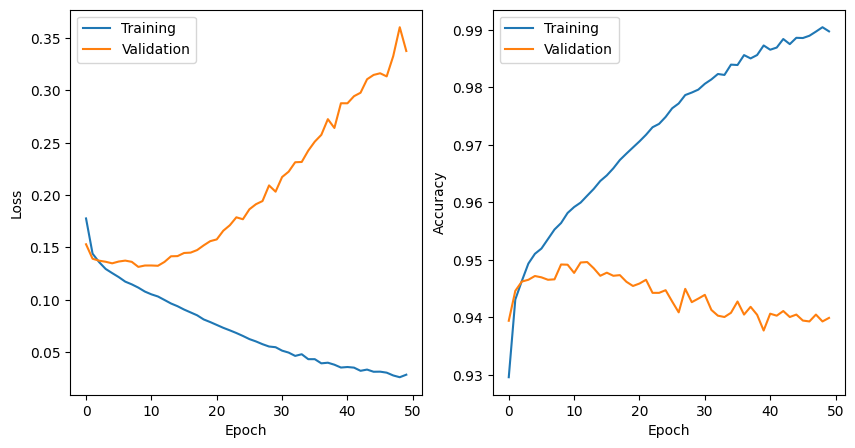

In [66]:
plot_model_history(history_e)

We see it has a very nice roc curve now. It performs around 6-9% better than the out of the box NN version. The scaled NN AUC closesly resembles the BDT version, only slightly (0.5%) worse. There does appear to be some overfitting.

# Optional refinements

Add further refinements to the neural network in the last step of the previous exercise. Try and get the classification as good as you can. For example, consider batchnorm, layer initialization, dropout, wider/deeper nets, .... . If you can't find a significant improvement, just show the code and report on the result of a few experiments (I tried X because I thought/saw Y, result was Z).

The scaling really worked well together with Adam, so we keep that. Now we can apply other things as well.

In [67]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from tensorflow.keras.optimizers import Adam

def run_experiment(hidden_layers, use_batchnorm=False, dropout_rate=0.0, kernel_initializer='glorot_uniform'):

    inputs = Input(shape=(X_train_scaled.shape[1],))

    x = inputs
    for units in hidden_layers:
        x = Dense(units, activation='relu', kernel_initializer=kernel_initializer)(x)
        if use_batchnorm:
            x = BatchNormalization()(x)
        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_scaled, y_train_filtered, epochs=50, batch_size=128, validation_data=(X_test_scaled, y_test_filtered), verbose=0)

    preds = model.predict(X_test_scaled)

    auc = roc_auc_score(y_test_filtered, preds)

    print(f"AUC: {auc:.6f}")

    roc_plot = plot_roc(y_test_filtered, preds)
    
    return model, history, auc, roc_plot

### Experiment 1: Batch Normalization

811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC: 0.980778


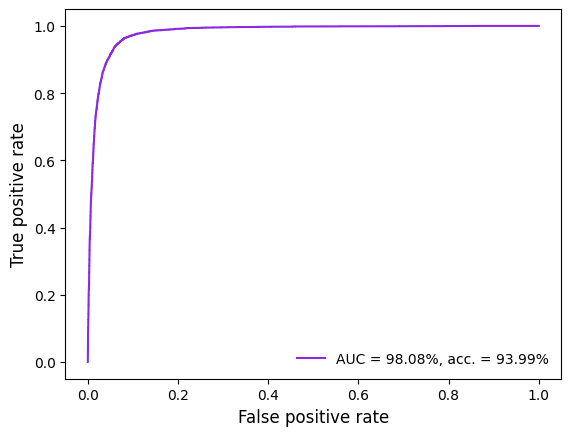

In [68]:
model_bn, history_bn, auc_bn, roc_plot_bn = run_experiment(
    hidden_layers=[128, 128, 128],
    use_batchnorm=True,
    dropout_rate=0.0,
    kernel_initializer=GlorotUniform()
)

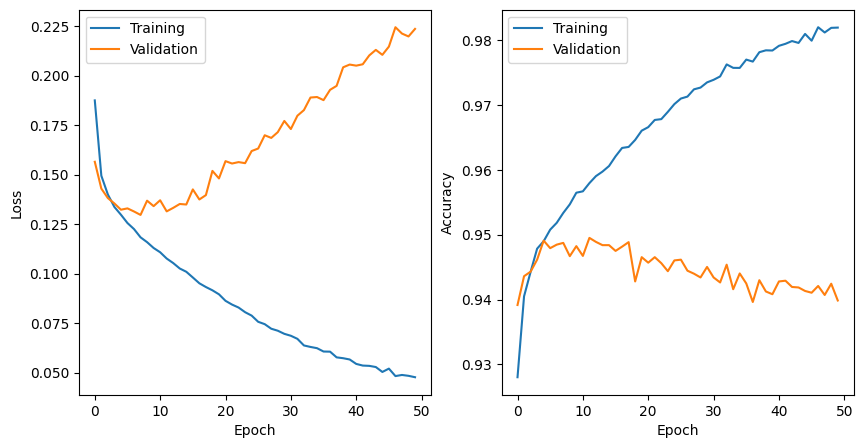

In [69]:
plot_model_history(history_bn)

Is a bit better than the scaled version and pretty close to the BDT. But it looks like we have some overfitting.

### Experiment 2: Dropout

811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC: 0.986711


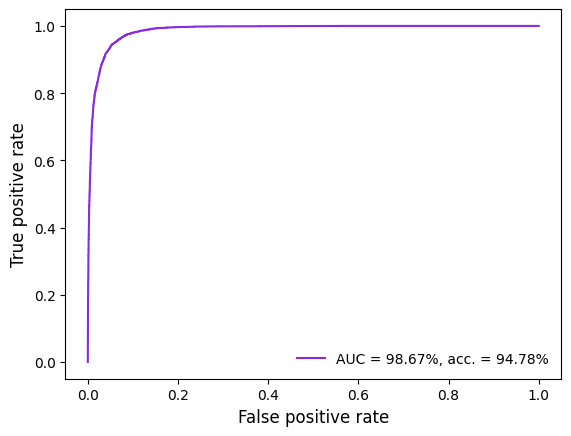

In [70]:
model_do, history_do, auc_do, roc_plot_do = run_experiment(
    hidden_layers=[128, 128, 128],
    use_batchnorm=False,
    dropout_rate=0.5,
    kernel_initializer=GlorotUniform()
)

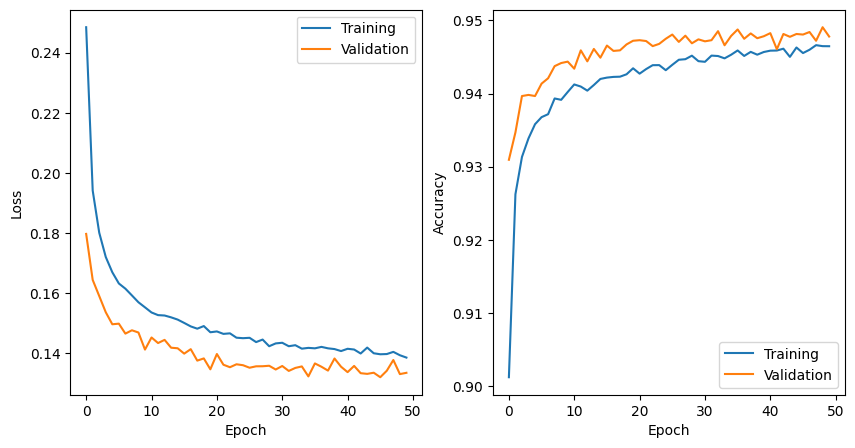

In [71]:
plot_model_history(history_do)

Outperforms the BDT! And there is less/little overfitting.

### Experiment 3: Layer Initialization (He Normal)

811/811 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC: 0.977308


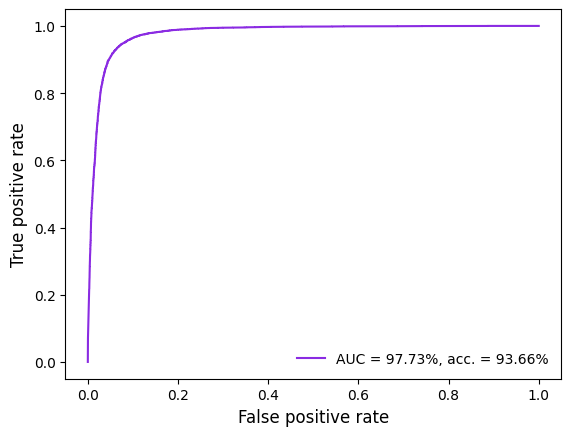

In [72]:
model_he, history_he, auc_he, roc_plot_he = run_experiment(
    hidden_layers=[128, 128, 128],
    use_batchnorm=False,
    dropout_rate=0.0,
    kernel_initializer=HeNormal()
)

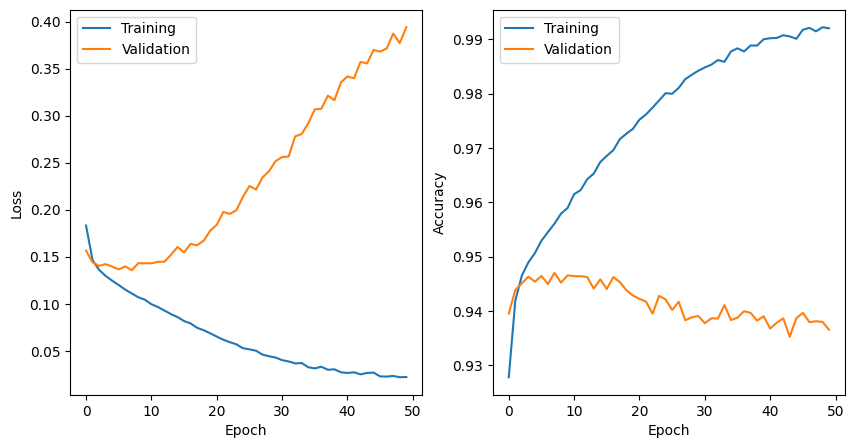

In [73]:
plot_model_history(history_he)

This gives a small improvement over the scaled model. He initialization sets weight variance around 2/fan_in (vs Glorot/Xavier's 1/fan_in), so the weight std is larger by sqrt(2). Because ReLU zeros about half the activations, the larger init preserves the post‑ReLU activation variance (prevents signal shrinking).

### Experiment 4: Wider and Deeper Networks

wide

In [ ]:
model_wide, history_wide, auc_wide, roc_plot_wide = run_experiment(
    hidden_layers=[256, 256, 128],
    use_batchnorm=False,
    dropout_rate=0.0,
    kernel_initializer=GlorotUniform()
)

In [ ]:
plot_model_history(history_wide)

deeper

AUC: 0.978091


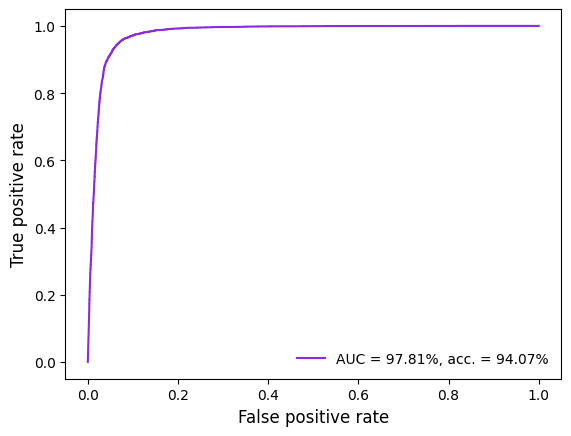

In [ ]:
model_deep, history_deep, auc_deep, roc_plot_deep = run_experiment(
    hidden_layers=[128, 128, 128, 64, 64],
    use_batchnorm=False,
    dropout_rate=0.0,
    kernel_initializer=GlorotUniform()
)

In [ ]:
plot_model_history(history_deep)

### Combine stuff

We use a deeper and wider network with batch normalization, a drop out rate of 0.5 and HeNormal kernal initializer

In [ ]:
model_co, history_co, auc_co, roc_plot_co = run_experiment(
    hidden_layers=[256, 256, 128, 64],
    use_batchnorm=True,
    dropout_rate=0.5,
    kernel_initializer=HeNormal()
)

NameError: name 'Input' is not defined

In [ ]:
plot_model_history(history_co)

### Compare Optional Experiments

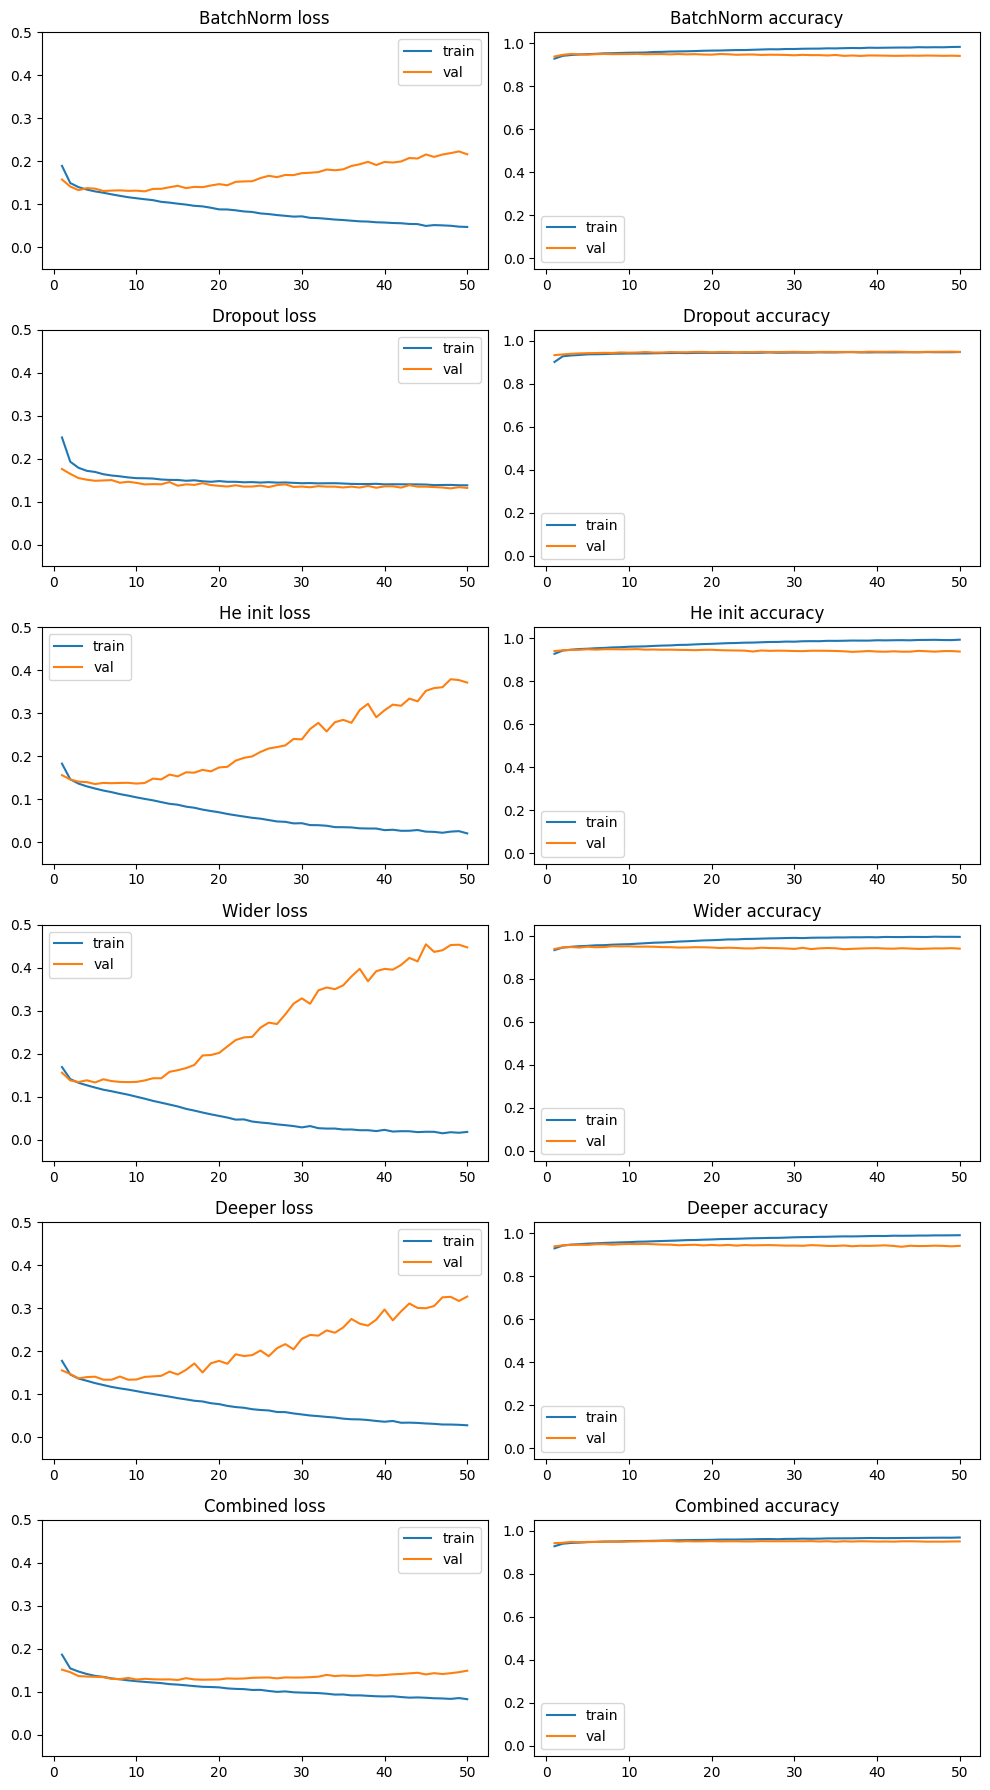

Train AUC  |  Test AUC  |  Gap   | Model
0.9993    0.9801    0.0191   BatchNorm
0.9896    0.9869    0.0027   Dropout
0.9998    0.9802    0.0196   He init
0.9999    0.9804    0.0195   Wider
0.9996    0.9781    0.0215   Deeper
0.9976    0.9857    0.0120   Combined


In [ ]:
models = [
    ("BatchNorm", model_bn, history_bn),
    ("Dropout", model_do, history_do),
    ("He init", model_he, history_he),
    ("Wider", model_wide, history_wide),
    ("Deeper", model_deep, history_deep),
    ("Combined", model_co, history_co)
]

# Plot train/val loss and accuracy for each experiment (stacked)
fig, axes = plt.subplots(len(models), 2, figsize=(10, 3 * len(models)))
for i, (name, m, h) in enumerate(models):
    ep = range(1, len(h.history["loss"]) + 1)
    axes[i, 0].plot(ep, h.history["loss"], label="train")
    axes[i, 0].plot(ep, h.history["val_loss"], label="val")
    axes[i, 0].set_ylim(-0.05,0.5)
    axes[i, 0].set_title(f"{name} loss"); axes[i, 0].legend()

    axes[i, 1].plot(ep, h.history["accuracy"], label="train")
    axes[i, 1].plot(ep, h.history["val_accuracy"], label="val")
    axes[i, 1].set_ylim(0.8, 1.05)
    axes[i, 1].set_title(f"{name} accuracy"); axes[i, 1].legend()

plt.tight_layout()
plt.show()

# Compute train vs test AUC gap
print("Train AUC  |  Test AUC  |  Gap   | Model")
for name, m, h in models:
    preds_train = m.predict(X_train_scaled)
    preds_test  = m.predict(X_test_scaled)
    auc_train = roc_auc_score(y_train_filtered, preds_train)
    auc_test  = roc_auc_score(y_test_filtered,  preds_test)
    print(f"{auc_train:.4f}    {auc_test:.4f}    {auc_train-auc_test:.4f}   {name}")